<h1 align="center"><font size="5">IBM Applied Science Capstone</font></h1>

This is a capstone project to the IBM Applied Science Certificate Course.

Lets first load required libraries:

In [1]:
#Put all imports here vice throughout
import itertools
import datetime
import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
%matplotlib inline
print("Done")

Done


### 1. Introduction

#### 1.1 Background

The city of Seattle, Washington has made public a dataset containing collision data from Jan 2004 through May 2020.  Seattle makes their data openly available to the public in an apparent attempt to be more transparent.  Additional information can be found:  https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0

#### 1.2 Statement of Problem - Objective

The objective is to predict traffic accident severity given the available data (severity values: 1 = Property Damage Only Collision, 2 = Injury Collision).

#### 1.3 Interest

Other cities may benefit by understanding various factors leading to accident severity, and may want to consider these findings in city planning.  In addition, all levels of government, transportation manufacturers, innovators and insurance companies may be interested in these findings to improve current systems.  People, in general, may benefit from understanding the risks.

### 2. "Business Understanding" - Data Acquisition and Initial Examination

#### 2.1 About the Dataset

The initial dataset was obtained via:  https://www.coursera.org/learn/applied-data-science-capstone/supplement/Nh5uS/downloading-example-dataset

The metadata was obtained via:  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf

#### 2.2 Initial Data Set Review and Discussion

Initial review indicates likely use of categorical supervised learning methods.

The accident "participants" are: Motor Vehicles, Driverless Vehicles, Pedacyclists, Pedestrians with several records not applicable.  There are some incidental 'participants', namely objects, trains, etc.  

The data from 2020 seems to have less rich data, appearing incomplete in general.  Thus for purposes of this capstone project and the prediction alogrithm, it may make sense to limit the dates used to create the alogrithm.

There appears to be some more interesting data which will help the analysis and model development.  Some may possibly require transformation for categorical supervised learning: 
- Environmental Factors (e.g., Weather, Road, Light).  Note:  Crosswalk may be a factor, but crosswalks are generally in intersections
- Human Factors (e.g., Driver Attentiveness, Speeding)
- #s Involved (e.g., People, Bikes, Vehicles)
- Time: Time is on the 24 hour scale, and time of day, specifically hour of day, may contribute
- Date: Weekend / Weekday / Holiday may, but likely not given the Objective and participants
- Address Type or Junction Type

Some data appears less relevant to any algorithmm but may be generally informative:

- Indices/Keys, Lat/Long/Specific Address, Location/Intersection Key and similar data

And there is duplicative data between the city of Seattle and Washington State:
- Upon initial examination, the Seattle Department of Transportation (SDOT) data is more complete than the Washington State data with better descriptions.  The Washington State (ST) data appears much less complete/accurate.
- Status appears related to the difference between ST and SDOT data.  There is strong correlation between an unmatched status, lack of a time stamp, and lack of other amplifying information.

To complete this analysis, the more interesting data listed above will be explored.  The remaining data may be initially examined to assess its potential use.  Some data appears to be less useful and will be dropped going forward.

For the purposes herein, the following supervised learning models will be explored for prediction accuracy:
- K Nearest Neighbor(KNN)
- Decision Tree (DT)
- Support Vector Machine (SVM)
- Logistic Regression (LR)

To begin, download the dataset

In [2]:
#Import the data into a pandas dataframe
#Note: Added no ("N") to SPEEDING and INATTENTIONIND in .csv file if not explicitly yes ("Y") to save a step
init_df=pd.read_csv(r'C:\Users\User\Desktop\Coursera\IBM\9_Applied Data Science Capstone\Data_Collisions.csv', low_memory=False)
print("Success!")

Success!


#### 2.3 Loading and Exploring the Initial Data File for Feature Selection

In [3]:
#Explore the initial dataframe
init_df.head()

SEVERITYCODE           X          Y  OBJECTID  INCKEY  COLDETKEY REPORTNO  \
0             2 -122.323148  47.703140         1    1307       1307  3502005   
1             1 -122.347294  47.647172         2   52200      52200  2607959   
2             1 -122.334540  47.607871         3   26700      26700  1482393   
3             1 -122.334803  47.604803         4    1144       1144  3503937   
4             2 -122.306426  47.545739         5   17700      17700  1807429   

    STATUS      ADDRTYPE   INTKEY  ...   WEATHER ROADCOND  \
0  Matched  Intersection  37475.0  ...  Overcast      Wet   
1  Matched         Block      NaN  ...   Raining      Wet   
2  Matched         Block      NaN  ...  Overcast      Dry   
3  Matched         Block      NaN  ...     Clear      Dry   
4  Matched  Intersection  34387.0  ...   Raining      Wet   

                 LIGHTCOND  PEDROWNOTGRNT SDOTCOLNUM ST_COLCODE  \
0                 Daylight            NaN        NaN         10   
1  Dark - Street Lights On            NaN  6354039.0         11   
2                 Daylight            NaN  4323031.0         32   
3                 Daylight            NaN        NaN         23   
4                 Daylight            NaN  4028032.0         10   

                                          ST_COLDESC  SEGLANEKEY  \
0                                  Entering at angle           0   
1  From same direction - both going straight - bo...           0   
2                             One parked--one moving           0   
3                   From same direction - all others           0   
4                                  Entering at angle           0   

   CROSSWALKKEY  HITPARKEDCAR  
0             0             N  
1             0             N  
2             0             N  
3             0             N  
4             0             N  

[5 rows x 38 columns]

In [4]:
#Explore the initial dataframe
init_df.shape

(194673, 38)

In [5]:
#Futher explore the initial dataframe
init_df.describe()

SEVERITYCODE              X              Y       OBJECTID  \
count  194673.000000  189339.000000  189339.000000  194673.000000   
mean        1.298901    -122.330518      47.619543  108479.364930   
std         0.457778       0.029976       0.056157   62649.722558   
min         1.000000    -122.419091      47.495573       1.000000   
25%         1.000000    -122.348673      47.575956   54267.000000   
50%         1.000000    -122.330224      47.615369  106912.000000   
75%         2.000000    -122.311937      47.663664  162272.000000   
max         2.000000    -122.238949      47.734142  219547.000000   

              INCKEY      COLDETKEY         INTKEY  SEVERITYCODE.1  \
count  194673.000000  194673.000000   65070.000000   194673.000000   
mean   141091.456350  141298.811381   37558.450576        1.298901   
std     86634.402737   86986.542110   51745.990273        0.457778   
min      1001.000000    1001.000000   23807.000000        1.000000   
25%     70383.000000   70383.000000   28667.000000        1.000000   
50%    123363.000000  123363.000000   29973.000000        1.000000   
75%    203319.000000  203459.000000   33973.000000        2.000000   
max    331454.000000  332954.000000  757580.000000        2.000000   

         PERSONCOUNT       PEDCOUNT    PEDCYLCOUNT       VEHCOUNT  \
count  194673.000000  194673.000000  194673.000000  194673.000000   
mean        2.444427       0.037139       0.028391       1.920780   
std         1.345929       0.198150       0.167413       0.631047   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       2.000000   
50%         2.000000       0.000000       0.000000       2.000000   
75%         3.000000       0.000000       0.000000       2.000000   
max        81.000000       6.000000       2.000000      12.000000   

        SDOT_COLCODE       SPEEDING  INATTENTIONIND    SDOTCOLNUM  \
count  194673.000000  194673.000000   194673.000000  1.149360e+05   
mean       13.867768       0.047942        0.153103  7.972521e+06   
std         6.868755       0.213644        0.360088  2.553533e+06   
min         0.000000       0.000000        0.000000  1.007024e+06   
25%        11.000000       0.000000        0.000000  6.040015e+06   
50%        13.000000       0.000000        0.000000  8.023022e+06   
75%        14.000000       0.000000        0.000000  1.015501e+07   
max        69.000000       1.000000        1.000000  1.307202e+07   

          SEGLANEKEY  CROSSWALKKEY  
count  194673.000000  1.946730e+05  
mean      269.401114  9.782452e+03  
std      3315.776055  7.226926e+04  
min         0.000000  0.000000e+00  
25%         0.000000  0.000000e+00  
50%         0.000000  0.000000e+00  
75%         0.000000  0.000000e+00  
max    525241.000000  5.239700e+06

In [6]:
#Create new dataframe by not including some columns of little initial value
proc_df1=init_df[["SEVERITYCODE","INCDTTM","STATUS","SDOT_COLDESC","X","Y","ADDRTYPE","PERSONCOUNT","PEDCOUNT","PEDCYLCOUNT","VEHCOUNT","SPEEDING","INATTENTIONIND","WEATHER","ROADCOND","LIGHTCOND"]]

In [7]:
#Explore the new dataframe
proc_df1.head()

SEVERITYCODE           INCDTTM   STATUS  \
0             2   3/27/2013 14:54  Matched   
1             1  12/20/2006 18:55  Matched   
2             1  11/18/2004 10:20  Matched   
3             1    3/29/2013 9:26  Matched   
4             2    1/28/2004 8:04  Matched   

                                        SDOT_COLDESC           X          Y  \
0  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.323148  47.703140   
1  MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ... -122.347294  47.647172   
2       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END -122.334540  47.607871   
3  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.334803  47.604803   
4  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.306426  47.545739   

       ADDRTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  SPEEDING  \
0  Intersection            2         0            0         2         0   
1         Block            2         0            0         2         0   
2         Block            4         0            0         3         0   
3         Block            3         0            0         3         0   
4  Intersection            2         0            0         2         0   

   INATTENTIONIND   WEATHER ROADCOND                LIGHTCOND  
0               0  Overcast      Wet                 Daylight  
1               0   Raining      Wet  Dark - Street Lights On  
2               0  Overcast      Dry                 Daylight  
3               0     Clear      Dry                 Daylight  
4               0   Raining      Wet                 Daylight

In [8]:
# Remove blank Environmental Conditions (i.e., ADDRTYPE, WEATHER, ROADCOND, LIGHTCOND)
proc_df2=proc_df1[~proc_df1['ADDRTYPE'].isnull()]
proc_df3=proc_df2[~proc_df2['WEATHER'].isnull()]
proc_df4=proc_df3[~proc_df3['ROADCOND'].isnull()]
proc_df5=proc_df4[~proc_df4['LIGHTCOND'].isnull()]
proc_df6=proc_df5[~proc_df5['X'].isnull()]
proc_df7=proc_df6[~proc_df6["Y"].isnull()]

In [9]:
# Check for any null values
proc_df7.isnull().values.any()

False

In [10]:
proc_df7.head()

SEVERITYCODE           INCDTTM   STATUS  \
0             2   3/27/2013 14:54  Matched   
1             1  12/20/2006 18:55  Matched   
2             1  11/18/2004 10:20  Matched   
3             1    3/29/2013 9:26  Matched   
4             2    1/28/2004 8:04  Matched   

                                        SDOT_COLDESC           X          Y  \
0  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.323148  47.703140   
1  MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ... -122.347294  47.647172   
2       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END -122.334540  47.607871   
3  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.334803  47.604803   
4  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.306426  47.545739   

       ADDRTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  SPEEDING  \
0  Intersection            2         0            0         2         0   
1         Block            2         0            0         2         0   
2         Block            4         0            0         3         0   
3         Block            3         0            0         3         0   
4  Intersection            2         0            0         2         0   

   INATTENTIONIND   WEATHER ROADCOND                LIGHTCOND  
0               0  Overcast      Wet                 Daylight  
1               0   Raining      Wet  Dark - Street Lights On  
2               0  Overcast      Dry                 Daylight  
3               0     Clear      Dry                 Daylight  
4               0   Raining      Wet                 Daylight

In [11]:
# Remove unknown data where impact is small (i.e., WEATHER, ROADCOND, LIGHTCOND)
# Remove unmatched records given higher unreliability
proc_df7 = proc_df6.loc[(proc_df6['WEATHER']!="Unknown")&(proc_df2['ROADCOND']!="Unknown")&(proc_df2['LIGHTCOND']!="Unknown")&(proc_df2['SDOT_COLDESC']!="NOT ENOUGH INFORMATION / NOT APPLICABLE")]
proc_df8 = proc_df7.loc[(proc_df7['STATUS']!="Unmatched")]

In [12]:
# Review Data
proc_df9=proc_df8.sort_values(by=['INCDTTM'], ascending=False)
proc_df9.head()

SEVERITYCODE        INCDTTM   STATUS  \
192339             2  9/9/2019 9:27  Matched   
191832             1  9/9/2019 9:08  Matched   
192599             1  9/9/2019 9:06  Matched   
190713             2  9/9/2019 8:45  Matched   
189493             2  9/9/2019 8:25  Matched   

                                             SDOT_COLDESC           X  \
192339       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END -122.304907   
191832  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.333636   
192599  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.312725   
190713       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END -122.337348   
189493  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.362963   

                Y      ADDRTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
192339  47.571923         Block            2         0            0         2   
191832  47.621987         Block            2         0            0         2   
192599  47.549773         Block            3         0            0         2   
190713  47.520472         Block            4         0            0         3   
189493  47.553722  Intersection            2         0            0         2   

        SPEEDING  INATTENTIONIND   WEATHER ROADCOND LIGHTCOND  
192339         1               0  Overcast      Dry  Daylight  
191832         0               0     Clear      Dry  Daylight  
192599         0               0  Overcast      Wet  Daylight  
190713         0               0   Raining      Wet  Daylight  
189493         0               0   Raining      Wet  Daylight

In [13]:
# More review
proc_df9.describe()

SEVERITYCODE              X              Y    PERSONCOUNT  \
count  164190.000000  164190.000000  164190.000000  164190.000000   
mean        1.331957    -122.330331      47.618973       2.518509   
std         0.470917       0.029785       0.056718       1.414466   
min         1.000000    -122.419032      47.495573       0.000000   
25%         1.000000    -122.348142      47.574192       2.000000   
50%         1.000000    -122.330276      47.614832       2.000000   
75%         2.000000    -122.311937      47.663667       3.000000   
max         2.000000    -122.238949      47.734142      81.000000   

            PEDCOUNT    PEDCYLCOUNT       VEHCOUNT       SPEEDING  \
count  164190.000000  164190.000000  164190.000000  164190.000000   
mean        0.041111       0.031707       1.975199       0.051562   
std         0.208454       0.176605       0.576228       0.221142   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       2.000000       0.000000   
50%         0.000000       0.000000       2.000000       0.000000   
75%         0.000000       0.000000       2.000000       0.000000   
max         6.000000       2.000000      11.000000       1.000000   

       INATTENTIONIND  
count   164190.000000  
mean         0.169005  
std          0.374758  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000

In [14]:
# More review
proc_df9.shape

(164190, 16)

In [15]:
# Check datatypes
proc_df9.dtypes

SEVERITYCODE        int64
INCDTTM            object
STATUS             object
SDOT_COLDESC       object
X                 float64
Y                 float64
ADDRTYPE           object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
SPEEDING            int64
INATTENTIONIND      int64
WEATHER            object
ROADCOND           object
LIGHTCOND          object
dtype: object

At this point, a count of 30,483 records have been cleaned / removed which had some issue (e.g., conflicting or missing data).

### 3 Methodology:  Deeper Data Understanding and Data Transformation Stage

Some of the data requires transformation to be used in the algorithms.  The next several stages are the data transformation process.

#### 3.1 Transforming the Environmental Factors Data

In [16]:
# Replace ADDRTYPE category data with numerical values
proc_df9['ADDRTYPE'].replace(to_replace=['Alley','Block','Intersection'],value=[1,2,3],inplace=True)

In [17]:
# Replace WEATHER category data with numerical values
proc_df9['WEATHER'].replace(to_replace=['Clear','Raining','Other','Snowing','Fog/Smog/Smoke','Sleet/Hail/Freezing Rain','Blowing Sand/Dirt','Severe Crosswind','Partly Cloudy','Overcast'],value=[0,1,1,1,1,1,1,1,1,1],inplace=True)

In [18]:
# Replace ROADCOND category data with numerical values
proc_df9['ROADCOND'].replace(to_replace=['Dry','Wet','Snow/Slush','Ice','Other','Sand/Mud/Dirt','Standing Water','Oil'],value=[0,1,1,1,1,1,1,1],inplace=True)

In [19]:
# Replace LIGHTCOND category data with numerical values
proc_df9['LIGHTCOND'].replace(to_replace=['Daylight','Dark - Street Lights On','Dusk','Dawn','Dark - Street Lights Off','Dark - No Street Lights','Dark - Unknown Lighting','Other'],value=[0,1,1,1,1,1,1,1],inplace=True)

##### 3.2 Transforming the Impact Data

In [20]:
#Replace DRIVERLESS VEHICLE INITIATED categories with numerical values for assessment. Note:  Reduced type and angles for simplification
proc_df9['SDOT_COLDESC'].replace(to_replace=['DRIVERLESS VEHICLE RAN OFF ROAD - NO COLLISION','DRIVERLESS VEHICLE RAN OFF ROAD - HIT FIXED OBJECT','DRIVERLESS VEHICLE STRUCK OBJECT IN ROADWAY'], value=[1,2,3],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE FRONT END AT ANGLE','DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SIDE AT ANGLE','DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SIDE SIDESWIPE','DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE REAR END','DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE AT ANGLE','DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE SIDESWIPE', 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE REAR END','DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE AT ANGLE '], value=[4,5,6,7,8,9,10,11],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['DRIVERLESS VEHICLE STRUCK PEDESTRIAN'], value=[12],inplace=True)

In [21]:
#Replace MOTOR VEHICLE INITIATED categories with numerical values for assessment. Note:  Reduced type and angles for simplification
proc_df9['SDOT_COLDESC'].replace(to_replace=['MOTOR VEHICLE RAN OFF ROAD - NO COLLISION'], value=[13],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['MOTOR VEHICLE OVERTURNED IN ROAD','MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT','MOTOR VEHICLE STRUCK OBJECT IN ROAD'], value=[14,15,16],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE','MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE','MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE','MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END','MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE','MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE','MOTOR VEHICLE STRUCK TRAIN'], value=[17,18,19,20,21,22,23],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE','MOTOR VEHICLE STRUCK PEDALCYCLIST, LEFT SIDE SIDESWIPE','MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END','MOTOR VEHICLE STRUCK PEDALCYCLIST, RIGHT SIDE SIDESWIPE'], value=[24,25,26,27],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['MOTOR VEHCILE STRUCK PEDESTRIAN'], value=[28],inplace=True)

In [22]:
#Replace PEDALCYCLIST INITIATED categories with numerical values for assessment. Note:  Reduced type and angles for simplification
proc_df9['SDOT_COLDESC'].replace(to_replace=['PEDALCYCLIST OVERTURNED IN ROAD','PEDALCYCLIST RAN OFF ROAD - HIT FIXED OBJECT','PEDALCYCLIST STRUCK OBJECT IN ROAD'], value=[29,30,31],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ANGLE','PEDALCYCLIST STRUCK MOTOR VEHICLE LEFT SIDE AT ANGLE','PEDALCYCLIST STRUCK MOTOR VEHICLE LEFT SIDE SIDESWIPE','PEDALCYCLIST STRUCK MOTOR VEHICLE REAR END','PEDALCYCLIST STRUCK MOTOR VEHICLE RIGHT SIDE AT ANGLE','PEDALCYCLIST STRUCK MOTOR VEHICLE RIGHT SIDE SIDESWIPE'], value=[32,33,34,35,36,37],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['PEDALCYCLIST STRUCK PEDALCYCLIST FRONT END AT ANGLE','PEDALCYCLIST STRUCK PEDALCYCLIST REAR END'], value=[38,39],inplace=True)
proc_df9['SDOT_COLDESC'].replace(to_replace=['PEDALCYCLIST STRUCK PEDESTRIAN'], value=[40],inplace=True)

##### 3.3 Interim Review of the Data

In [ ]:
# The next several steps are a literal review of all data fields to explore richness and validity following transformation.

In [23]:
proc_df9.describe()

SEVERITYCODE   SDOT_COLDESC              X              Y  \
count  164190.000000  164190.000000  164190.000000  164190.000000   
mean        1.331957      18.617876    -122.330331      47.618973   
std         0.470917       3.062602       0.029785       0.056718   
min         1.000000       1.000000    -122.419032      47.495573   
25%         1.000000      17.000000    -122.348142      47.574192   
50%         1.000000      17.000000    -122.330276      47.614832   
75%         2.000000      20.000000    -122.311937      47.663667   
max         2.000000      40.000000    -122.238949      47.734142   

            ADDRTYPE    PERSONCOUNT       PEDCOUNT    PEDCYLCOUNT  \
count  164190.000000  164190.000000  164190.000000  164190.000000   
mean        2.369730       2.518509       0.041111       0.031707   
std         0.482733       1.414466       0.208454       0.176605   
min         2.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.000000       0.000000       0.000000   
50%         2.000000       2.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max         3.000000      81.000000       6.000000       2.000000   

            VEHCOUNT       SPEEDING  INATTENTIONIND        WEATHER  \
count  164190.000000  164190.000000   164190.000000  164190.000000   
mean        1.975199       0.051562        0.169005       0.359571   
std         0.576228       0.221142        0.374758       0.479876   
min         0.000000       0.000000        0.000000       0.000000   
25%         2.000000       0.000000        0.000000       0.000000   
50%         2.000000       0.000000        0.000000       0.000000   
75%         2.000000       0.000000        0.000000       1.000000   
max        11.000000       1.000000        1.000000       1.000000   

            ROADCOND      LIGHTCOND  
count  164190.000000  164190.000000  
mean        0.284183       0.336476  
std         0.451026       0.472505  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         1.000000       1.000000  
max         1.000000       1.000000

In [24]:
proc_df9.SEVERITYCODE.unique()

array([2, 1], dtype=int64)

In [25]:
proc_df9.SDOT_COLDESC.unique()

array([20, 17, 28, 15, 16, 32, 24, 22, 18,  2, 19, 14, 40, 21, 26, 10, 34,
        5,  4, 37, 29, 13, 25, 35,  9, 23, 31, 27, 30,  1, 39,  3, 11, 33,
       38, 36,  6, 12], dtype=int64)

In [26]:
proc_df9.ADDRTYPE.unique()

array([2, 3], dtype=int64)

In [27]:
proc_df9.PERSONCOUNT.unique()

array([ 2,  3,  4, 10,  5,  1,  0,  6,  8,  7, 48,  9, 17, 29, 11, 12, 14,
       13, 16, 20, 35, 43, 44, 57, 34, 25, 26, 19, 36, 32, 15, 31, 30, 22,
       24, 39, 47, 53, 21, 27, 37, 18, 54, 23, 81, 41, 28], dtype=int64)

In [28]:
proc_df9.PEDCOUNT.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [29]:
proc_df9.PEDCYLCOUNT.unique()

array([0, 1, 2], dtype=int64)

In [30]:
proc_df9.VEHCOUNT.unique()

array([ 2,  3,  1,  4,  0,  5,  6,  9,  8,  7, 11, 10], dtype=int64)

In [31]:
proc_df9.SPEEDING.unique()

array([1, 0], dtype=int64)

In [32]:
proc_df9.INATTENTIONIND.unique()

array([0, 1], dtype=int64)

In [33]:
proc_df9.WEATHER.unique()

array([1, 0], dtype=int64)

In [34]:
proc_df9.ROADCOND.unique()

array([0, 1], dtype=int64)

In [35]:
proc_df9.LIGHTCOND.unique()

array([0, 1], dtype=int64)

In [36]:
proc_df9.head()

SEVERITYCODE        INCDTTM   STATUS  SDOT_COLDESC           X  \
192339             2  9/9/2019 9:27  Matched            20 -122.304907   
191832             1  9/9/2019 9:08  Matched            17 -122.333636   
192599             1  9/9/2019 9:06  Matched            17 -122.312725   
190713             2  9/9/2019 8:45  Matched            20 -122.337348   
189493             2  9/9/2019 8:25  Matched            17 -122.362963   

                Y  ADDRTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
192339  47.571923         2            2         0            0         2   
191832  47.621987         2            2         0            0         2   
192599  47.549773         2            3         0            0         2   
190713  47.520472         2            4         0            0         3   
189493  47.553722         3            2         0            0         2   

        SPEEDING  INATTENTIONIND  WEATHER  ROADCOND  LIGHTCOND  
192339         1               0        1         0          0  
191832         0               0        0         0          0  
192599         0               0        1         1          0  
190713         0               0        1         1          0  
189493         0               0        1         1          0

In [37]:
proc_df9.dtypes

SEVERITYCODE        int64
INCDTTM            object
STATUS             object
SDOT_COLDESC        int64
X                 float64
Y                 float64
ADDRTYPE            int64
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
SPEEDING            int64
INATTENTIONIND      int64
WEATHER             int64
ROADCOND            int64
LIGHTCOND           int64
dtype: object

At this interim stage, the data have been transformed and are properly formatted with the noted exception of the incident date and time (INCDTTM).

#### 3.4 Perform the DateTime Transformation  

In [38]:
#Setting dataframe for exploration via visualization by setting extracting event hour and converting the data as integer, then merging datasets 
proc_df9["INCDTTM"]=pd.to_datetime(proc_df8["INCDTTM"])
proc_df9["HOUR"]=proc_df9["INCDTTM"].dt.hour
proc_df10=proc_df9[["HOUR","SEVERITYCODE","SDOT_COLDESC","ADDRTYPE","PERSONCOUNT","PEDCYLCOUNT","VEHCOUNT","SPEEDING","INATTENTIONIND","WEATHER","ROADCOND","LIGHTCOND"]].astype(int)
df=proc_df10

In [39]:
df.head()

HOUR  SEVERITYCODE  SDOT_COLDESC  ADDRTYPE  PERSONCOUNT  PEDCYLCOUNT  \
192339     9             2            20         2            2            0   
191832     9             1            17         2            2            0   
192599     9             1            17         2            3            0   
190713     8             2            20         2            4            0   
189493     8             2            17         3            2            0   

        VEHCOUNT  SPEEDING  INATTENTIONIND  WEATHER  ROADCOND  LIGHTCOND  
192339         2         1               0        1         0          0  
191832         2         0               0        0         0          0  
192599         2         0               0        1         1          0  
190713         3         0               0        1         1          0  
189493         2         0               0        1         1          0

#### 3.5 Data Visualization and Exploration

Let's look at some counts and create some new variables

In [40]:
# Count severity code.  The data indicate ~1/3 of all incidents result in injury.
df['SEVERITYCODE'].value_counts()

1    109686
2     54504
Name: SEVERITYCODE, dtype: int64

In [41]:
# Create Environmental_Factors (ENV_FAC) variable from WEATHER, ROADCOND, LIGHTCOND.
# This variable was created to indicate whether any environmental factor contributed to an incident with a count thereof.
df['ENV_FAC']=df['WEATHER']+df['ROADCOND']+df['LIGHTCOND']
df.ENV_FAC.astype(int)

192339    1
191832    0
192599    2
190713    2
189493    2
         ..
10714     3
8466      2
15284     2
7103      3
3291      2
Name: ENV_FAC, Length: 164190, dtype: int32

In [42]:
# Create Human_Factors variable (HUM_FAC) from SPEEDING, INATTENTIONIND
# This variable was created to indicate whether any known human factor contributed to an incident with a count thereof.
df['HUM_FAC']=df['SPEEDING']+df['INATTENTIONIND']
df.HUM_FAC.astype(int)

192339    1
191832    0
192599    0
190713    0
189493    0
         ..
10714     1
8466      0
15284     0
7103      0
3291      0
Name: HUM_FAC, Length: 164190, dtype: int32

In [43]:
# Create Contributing_Factors (CONTR_FAC) variable from Environmental_Factors, Human_Factors
# This variable was created to indicate whether or not any factor contributed with a count thereof.
df['CONTR_FAC']=df['ENV_FAC']+df['HUM_FAC']
df.CONTR_FAC.astype(int)

192339    2
191832    0
192599    2
190713    2
189493    2
         ..
10714     4
8466      2
15284     2
7103      3
3291      2
Name: CONTR_FAC, Length: 164190, dtype: int32

In [44]:
# Count non-zero Contributing Factors (CONTR_FAC).  Indicates 65% of incidents has some contributing factor.
sum(x>0 for x in df.CONTR_FAC) / 164190

0.6516292100615141

In [45]:
df=df[["HOUR","SEVERITYCODE","SDOT_COLDESC","ADDRTYPE","PERSONCOUNT","PEDCYLCOUNT","VEHCOUNT","HUM_FAC","ENV_FAC","CONTR_FAC"]].astype(int)
df.head()

HOUR  SEVERITYCODE  SDOT_COLDESC  ADDRTYPE  PERSONCOUNT  PEDCYLCOUNT  \
192339     9             2            20         2            2            0   
191832     9             1            17         2            2            0   
192599     9             1            17         2            3            0   
190713     8             2            20         2            4            0   
189493     8             2            17         3            2            0   

        VEHCOUNT  HUM_FAC  ENV_FAC  CONTR_FAC  
192339         2        1        1          2  
191832         2        0        0          0  
192599         2        0        2          2  
190713         3        0        2          2  
189493         2        0        2          2

In [46]:
# One last look for nulls
df.isnull().values.any()

False

#### 3.6 Plotting Some Data for Insights

Lets plot some columns to underestand data better:

In [ ]:
# notice: if running this code, be sure seaborne is installed. Installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

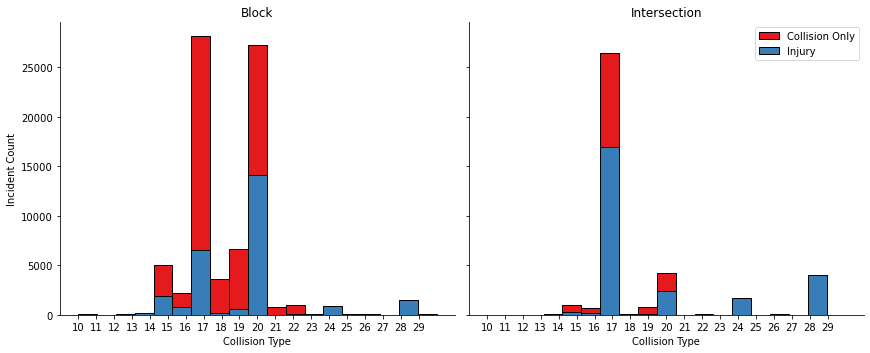

In [47]:
# Create another visualization separating by SEVERITYCODE to explore the data - similar results
bins = np.linspace(10,30,20)
g2 = sns.FacetGrid(df, col="ADDRTYPE", hue="SEVERITYCODE", palette="Set1", col_wrap=2, height=5, aspect=1.2)
g2.map(plt.hist, 'SDOT_COLDESC', align="mid", bins=bins, ec="k")
g2.set(xticks=np.arange(10,30,1))

axes0_title='Block'
axes1_title='Intersection'
ylabel='Incident Count'
xlabel='Collision Type'

axes = g2.axes.flatten()
axes[0].set_title(axes0_title)
axes[0].set_ylabel(ylabel)
for ax in axes:
    ax.set_xlabel(xlabel)
axes[1].set_title(axes1_title)

# change legend texts
new_labels = ['Collision Only', 'Injury']

g2.axes[-1].legend(new_labels)
plt.show()

#### 3.7 Exploring Time of Day, Human Factors and Environmental Factors 

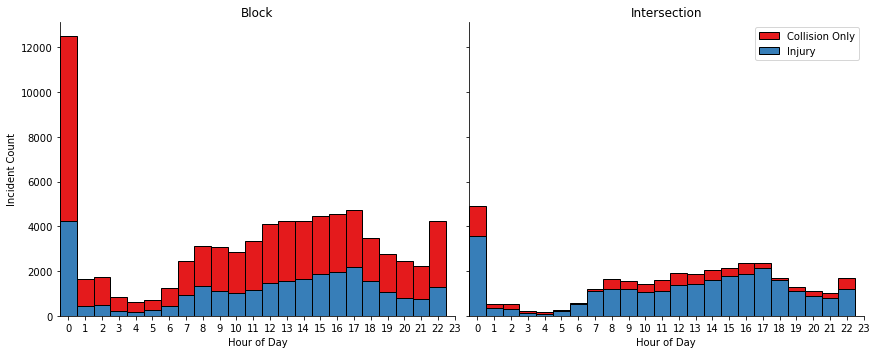

In [48]:
# Create visualization to explore other aspects (e.g., by HOUR)
# Data at 0 hour seems to be an extreme outlier.  Otherwise, the number of hour events appear to follow the typical pattern of life.

g3 = sns.FacetGrid(df, col="ADDRTYPE", hue="SEVERITYCODE", palette="Set1", col_wrap=2, height=5, aspect=1.2)
g3.map(plt.hist, 'HOUR', bins=23, align="left", edgecolor="k")
g3.set(xlim=(-.5,22.5))
g3.set(ylim=(0,None))
g3.set(xticks=np.arange(0,23.5,1))

axes0_title='Block'
axes1_title='Intersection'
ylabel='Incident Count'
xlabel='Hour of Day'

axes = g3.axes.flatten()
axes[0].set_title(axes0_title)
axes[0].set_ylabel(ylabel)
for ax in axes:
    ax.set_xlabel(xlabel)
axes[1].set_title(axes1_title)

# change legend texts
new_labels = ['Collision Only', 'Injury']

g3.axes[-1].legend(new_labels)
plt.show()

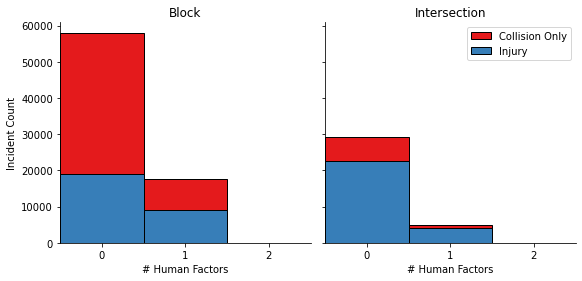

In [49]:
# Create visualization to explore other contributing aspects like human factors (e.g., by SPEEDING and INATTENTIVENESS)

g4 = sns.FacetGrid(df, col="ADDRTYPE", hue="SEVERITYCODE", palette="Set1", col_wrap=2, height=4, aspect=1)
g4.map(plt.hist, 'HUM_FAC', bins=2, align="left", edgecolor="k")
g4.set(xlim=(-.5,2.5))
g4.set(ylim=(0,None))
g4.set(xticks=np.arange(0,3,1))

axes0_title='Block'
axes1_title='Intersection'
ylabel='Incident Count'
xlabel='# Human Factors'

axes = g4.axes.flatten()
axes[0].set_title(axes0_title)
axes[0].set_ylabel(ylabel)
for ax in axes:
    ax.set_xlabel(xlabel)
axes[1].set_title(axes1_title)

# change legend texts
new_labels = ['Collision Only', 'Injury']

g4.axes[-1].legend(new_labels)
plt.show()

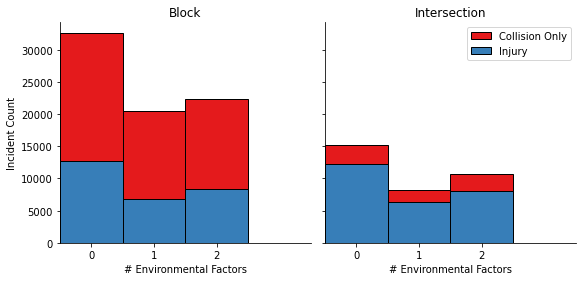

In [50]:
# Create visualization to explore aspects like environmental factors (e.g., by WEATHER, LIGHTING)

g5 = sns.FacetGrid(df, col="ADDRTYPE", hue="SEVERITYCODE", palette="Set1", col_wrap=2, height=4, aspect=1)
g5.map(plt.hist, 'ENV_FAC', bins=3, align="left",edgecolor="k")
g5.set(xlim=(-.5,3.5))
g5.set(ylim=(0,None))
g5.set(xticks=np.arange(0,3,1))

axes0_title='Block'
axes1_title='Intersection'
ylabel='Incident Count'
xlabel='# Environmental Factors'

axes = g5.axes.flatten()
axes[0].set_title(axes0_title)
axes[0].set_ylabel(ylabel)
for ax in axes:
    ax.set_xlabel(xlabel)
axes[1].set_title(axes1_title)

# change legend texts
new_labels = ['Collision Only', 'Injury']

g5.axes[-1].legend(new_labels)
plt.show()

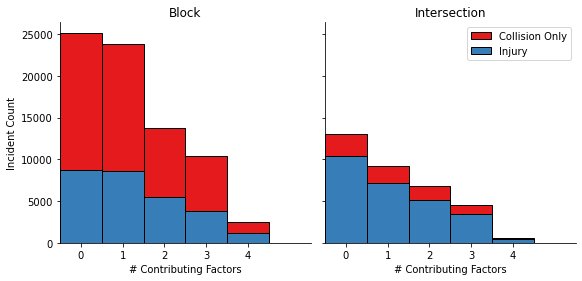

In [51]:
# Create visualization to explore any contributing aspects whether environmental or human factors
g6 = sns.FacetGrid(df, col="ADDRTYPE", hue="SEVERITYCODE", palette="Set1", col_wrap=2, height=4, aspect=1)
g6.map(plt.hist, 'CONTR_FAC', bins=5, align="left",edgecolor="k")
g6.set(xlim=(-.5,5.5))
g6.set(ylim=(0,None))
g6.set(xticks=np.arange(0,5,1))

axes0_title='Block'
axes1_title='Intersection'
ylabel='Incident Count'
xlabel='# Contributing Factors'

axes = g6.axes.flatten()
axes[0].set_title(axes0_title)
axes[0].set_ylabel(ylabel)
for ax in axes:
    ax.set_xlabel(xlabel)
axes[1].set_title(axes1_title)

# change legend texts
new_labels = ['Collision Only', 'Injury']

g6.axes[-1].legend(new_labels)
plt.show()

#### 3.8 Interim Summary Data Findings

A) Intersection incidents tend to be 'head-on' and Block incidents tend to be 'rear-end'

B) Intersections: ~1/3 of total incidents occur in intersections with ~66% of these 'head-on' incidents resulting in injury
       a. Human factors (i.e., SPEEDING and INATTENTIVENESS) seem to be a minor factor.
       b. Environmental factors (i.e., LIGHTING, WEATHER, etc.) appear to contribute significantly
       
C) Block: ~2/3s of total incidents are within the block infrastructure:
       a. ~50% of these are 'rear-end' events with an ~50% injury rate
       b. ~50% of these are 'head-on' events with ~25% injury rate
       c. Human factors (i.e., SPEEDING and INATTENTIVENESS) seem to be a minor factor.
       d. Environmental factors (e.g., reduced visibility) seem to contribute in a major way
       
D) Regardless of location, when motor vehicles impact pedacyclists or pedestrians, the result is almost always injury.

E) Some Contributing Factor (e.g., Human or Environmental) is present in ~2/3s of all incidents.

E) The severity code ratios appear to hold across time of the day 

#### 3.9 Look at an Event Location Map to Explore Insights

In [52]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: ...working... done

# All requested packages already installed.

Folium installed and imported!


In [53]:
# Grab the folium plugins
from folium import plugins

In [54]:
# Create Map dataframe for map use. Note: Used processing dataframe 8 for map purposes.
t=5000
df_map=proc_df8.head(t)
df_map.head()

SEVERITYCODE           INCDTTM   STATUS  \
0             2   3/27/2013 14:54  Matched   
1             1  12/20/2006 18:55  Matched   
2             1  11/18/2004 10:20  Matched   
3             1    3/29/2013 9:26  Matched   
4             2    1/28/2004 8:04  Matched   

                                        SDOT_COLDESC           X          Y  \
0  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.323148  47.703140   
1  MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ... -122.347294  47.647172   
2       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END -122.334540  47.607871   
3  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.334803  47.604803   
4  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ... -122.306426  47.545739   

       ADDRTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  SPEEDING  \
0  Intersection            2         0            0         2         0   
1         Block            2         0            0         2         0   
2         Block            4         0            0         3         0   
3         Block            3         0            0         3         0   
4  Intersection            2         0            0         2         0   

   INATTENTIONIND   WEATHER ROADCOND                LIGHTCOND  
0               0  Overcast      Wet                 Daylight  
1               0   Raining      Wet  Dark - Street Lights On  
2               0  Overcast      Dry                 Daylight  
3               0     Clear      Dry                 Daylight  
4               0   Raining      Wet                 Daylight

In [55]:
# Setting Seattle, Washington lat/long values with initial display
latitude = 47.6062
longitude = -122.3321
seattle_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# Create a subgroup of 1000 records vice all records for plotting (i.e., too much time otherwise)
# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the incidents and add each to the incidents feature group
for lat, lng, in zip(df_map.Y, df_map.X):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=4, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
# add incidents to map
seattle_map.add_child(incidents)

seattle_map

#### 3.10 This map shows the same data but clustered with drill down descriptions

In [56]:
# let's look at an incident cluster map of Seattle
seattle_map2 = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents2 = plugins.MarkerCluster().add_to(seattle_map2)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_map.Y, df_map.X, df_map.SDOT_COLDESC):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents2)

# display map
seattle_map2

#### 3.11 Summary Map Findings

By examining the maps, the majority of incidents seem to occur in downtown area, which is to be expected.  Incidents in congested areas likely cause greater congestion and delays.

### 4 Methodology:  Exploring and Choosing a Prediction Model

#### 4.1 Classification 

For the purposes herein, the following supervised learning models will be explored for prediction accuracy
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

#### 4.2 Splitting the Data into Training and Validation/Test Sets

In [57]:
# Split the training data into a training set and validation set
# Test size 20% to preclude overfitting.  Random state 4 for consistency with class and keep consistent outputs.
# Used sklearn
# Explored a variety of variable combinations.  
X=df[["HOUR","SDOT_COLDESC","ADDRTYPE","PERSONCOUNT","PEDCYLCOUNT","VEHCOUNT","HUM_FAC","ENV_FAC"]]
y=df["SEVERITYCODE"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Training Set:', X_train.shape,  y_train.shape)
print ('Validation Set:', X_test.shape,  y_test.shape)

Training Set: (131352, 8) (131352,)
Validation Set: (32838, 8) (32838,)


#### 4.2 Trying K Nearest Neighbor(KNN)

In [58]:
# Determine which K performs best.
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMatrix = [];
for i in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    knn_yhat=neigh.predict(X_test)
    mean_acc[i-1] = metrics.accuracy_score(knn_yhat, y_test)
    std_acc[i-1]=np.std(knn_yhat==y_test)/np.sqrt(knn_yhat.shape[0])

mean_acc

array([0.64267008, 0.69608381, 0.67988306, 0.7044278 , 0.69127231,
       0.7128936 , 0.69644924, 0.71743103, 0.70878251, 0.71627383,
       0.71085328, 0.7202022 , 0.71542116, 0.72011085, 0.71758329,
       0.72068945, 0.71584749, 0.72011085, 0.71797917])

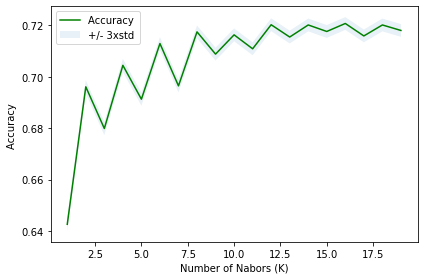

The best accuracy was with 0.7206894451550033 with k= 16


In [59]:
# Plot k_values to explore.  Variations in test size and random state change results here, but ends up looking like overfitting_underfitting
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [60]:
# Establish knn  
k=16
knn=KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
knn_yhat = knn.predict(X_test)
print("Validation Set Accuracy: ", metrics.accuracy_score(y_test, knn_yhat))

Validation Set Accuracy:  0.7206894451550033


In [61]:
print(confusion_matrix(y_test, knn_yhat))
print(classification_report(y_test, knn_yhat))

[[20289  1726]
 [ 7446  3377]]
              precision    recall  f1-score   support

           1       0.73      0.92      0.82     22015
           2       0.66      0.31      0.42     10823

    accuracy                           0.72     32838
   macro avg       0.70      0.62      0.62     32838
weighted avg       0.71      0.72      0.69     32838



In [62]:
# Set up variables and look at preliminary eval data
a=f1_score(y_test, knn_yhat,average='weighted')
b=jaccard_score(y_test, knn_yhat)
print("KNN F1 Score: ", a)
print("KNN Jaccard Score: ", b)

KNN F1 Score:  0.6865875472537922
KNN Jaccard Score:  0.6886731611282713


#### 4.4 Trying the Decision Tree

In [63]:
# Setup Decision Tree Classifier
dt=DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dt

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [64]:
#Setting up the training model
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [65]:
#Setting up the prediction model
dt_yhat=dt.predict(X_test)
print(dt_yhat [0:5])
print(y_test [0:5])

[1 1 1 2 1]
12181     2
52688     1
39863     1
112830    2
90546     1
Name: SEVERITYCODE, dtype: int32


In [66]:
#Print out preliminary evaluation information
print(confusion_matrix(y_test, dt_yhat))
print(classification_report(y_test, dt_yhat))

[[21488   527]
 [ 8523  2300]]
              precision    recall  f1-score   support

           1       0.72      0.98      0.83     22015
           2       0.81      0.21      0.34     10823

    accuracy                           0.72     32838
   macro avg       0.76      0.59      0.58     32838
weighted avg       0.75      0.72      0.66     32838



In [67]:
# Set up variables for scores to use later, and explore preliminary scores
c=f1_score(y_test, dt_yhat,average='weighted')
d=jaccard_score(y_test, dt_yhat)
print("Decision Tree Training and Validation Set F1 Score: ", c) 
print("Decision Tree Training and Validation Set Jaccard Score: ", d)

Decision Tree Training and Validation Set F1 Score:  0.6648629452318052
Decision Tree Training and Validation Set Jaccard Score:  0.7036479140742681


#### 4.5 Trying the Support Vector Machine

In [68]:
# Setup SVM and Train
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [69]:
# Establish svm_yhat
svm_yhat = clf.predict(X_test)
svm_yhat [0:5]

array([1, 1, 1, 2, 1])

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, svm_yhat)
np.set_printoptions(precision=2)

print (classification_report(y_test, svm_yhat))

              precision    recall  f1-score   support

           1       0.71      0.99      0.83     22015
           2       0.89      0.19      0.31     10823

    accuracy                           0.72     32838
   macro avg       0.80      0.59      0.57     32838
weighted avg       0.77      0.72      0.66     32838



In [71]:
# Set up variables and look at preliminary eval data
e=f1_score(y_test, svm_yhat,average='weighted')
f=jaccard_score(y_test, svm_yhat)
print("SVM F1 Score: ", e)
print("SVM Jaccard Score: ", f)

SVM F1 Score:  0.6558522114721919
SVM Jaccard Score:  0.7059510296740716


#### 4.6 Trying Logistic Regression

In [72]:
# Set up logistic regression.  Used Liblinear vice rgb or other
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [73]:
#Set up prediction and log loss probability
LR_yhat = LR.predict(X_test)
yhat_prob=LR.predict_proba(X_test)
LR_prob=log_loss(y_test, yhat_prob)
LR_prob

0.5756586389644387

In [74]:
#Set up confusion matrix for Log Regression
LRcnf_matrix = confusion_matrix(LR_yhat, y_test)
print(LRcnf_matrix)
print(classification_report(LR_yhat, y_test))

[[21362  8469]
 [  653  2354]]
              precision    recall  f1-score   support

           1       0.97      0.72      0.82     29831
           2       0.22      0.78      0.34      3007

    accuracy                           0.72     32838
   macro avg       0.59      0.75      0.58     32838
weighted avg       0.90      0.72      0.78     32838



In [75]:
#Set up variables for later and look at preliminary eval data
h=f1_score(LR_yhat,y_test,average='weighted')
j=jaccard_score(LR_yhat,y_test)
l=log_loss(y_test, yhat_prob)

print("The LR F1 Score: ", h)
print("The LR Jaccard Score: ", j)
print("The LR LogLoss: ", l)

The LR F1 Score:  0.7797689068200271
The LR Jaccard Score:  0.7007610549796615
The LR LogLoss:  0.5756586389644387


#### 4.7 Comparing the Different Models

In [76]:
#Create lists
endex=['KNN','Decision Tree','SVM','Logistic Regression']
F1_Score=[a,c,e,h]
Jaccard=[b,d,f,j]
LogLoss=['NA','NA','NA',l]

#Create report.  Note values will vary based on initial data split (e.g., 15% vs 20%, random setting)
df=pd.DataFrame(Jaccard, index=endex)
df.columns=['Jaccard']
df.insert(loc=1,column='F1_Score',value=F1_Score)
df.insert(loc=2,column='LogLoss',value=LogLoss)
df.columns.name='Algorithm'
df

Algorithm             Jaccard  F1_Score   LogLoss
KNN                  0.688673  0.686588        NA
Decision Tree        0.703648  0.664863        NA
SVM                  0.705951  0.655852        NA
Logistic Regression  0.700761  0.779769  0.575659

### 5 Discussion

Re-examining the Summary Data and Mapping Findings:

A) Intersection incidents tend to be 'head-on' and Block events tend to be 'rear-end'. The data seem to indicate significance with 'head-on' and 'rear-end' collisions leading to injury vice impacts from other angles.

B) Intersection Incidents: ~1/3 of total incidents occur in intersections with ~66% of these 'head-on' incidents resulting in injury.
       a. Human factors (i.e., SPEEDING and INATTENTIVENESS) seem to be a minor factor.
       b. Environmental factors (i.e., LIGHTING, WEATHER, etc.) appear to contribute significantly

C) Block: ~2/3s of total incidents are within the block infrastructure:
       a. ~50% of these are 'rear-end' events with an ~50% injury rate
       b. ~50% of these are 'head-on' events with ~25% injury rate
       c. Human factors (i.e., SPEEDING and INATTENTIVENESS) seem to be a minor factor.
       d. Environmental factors (e.g., reduced visibility) seem to contribute in a major way

D) Regardless of location, when motor vehicles impact pedacyclists or pedestrians, the result is almost always injury.

E) A full ~65% of incidents had some sort of Contributing Factor.  Human factors (i.e., speeding and driver inattentiveness) along with environmental factors (i.e., weather, lighting, and road conditions) appear to contribute to a significant number of incidents.  These should be considered as necessary in city planning, transportation design, insurance, government research, etc.  For example, reducing speed when any of these conditions are present may help.

F) The severity code ratios appear to hold across time of the day.

G) While more incidents occur in 'Block' environments, the injury counts are similar for 'Block' and 'Intersection' incidents.  From a city planning perspective, much attention has been given to intersection design.  It appears it may be worth exploring options for "Block" traffic control to lower the overall number of injuries.

H) A clear majority of incidents occur in the downtown area, meaning locations with higher traffic congestion counts.  These incidents likely lead to higher levels of congestion and delay.

I) Based upon the available data, it appears a Logistic Regression algorithm can predict with ~70% accuracy whether or not an injury occured.  Several permutations were attempted.  The prediction model could be likely improved with better data collection regarding safety devices (e.g., airbags, lane change sensors, collision warning sensors, automatic braking).

### 6 Conclusion

In this assessment, the ability to predict the outcome from a collision incident achieved an ~70% accuracy rate.  Key factors arising from the assessment include 'head-on' collisions in the "Intersection" environment and 'rear-end' collisions in the "Block" environment.  More incidents occur in congested areas.  While these factors are key in city planning, other considerations like human factors (e.g., speeding and driver attentiveness) and environmental factors (e.g., visibility) play a role.

### 7 Future Directions

Several future efforts may help.

For City Planners:  Some means of educating the public on the dangers posed by 'rear-end' incidents while 'on the Block.'  Control methods may need researched and explored regarding the findings above to reduce risks.

For Transportation Manufacturers:  Exploration of sensors to aid in assisted braking, lane control, attention monitoring, etc. may reduce risks.

For Innovators:  Pursuit of developmental technologies to support City Planners, Transportation Manufacturers and Vehicle Operators in risk reduction.

For Insurers:  Incentivizing City Planners, Transportation Manufacturers and vehicles operators to purchase supporting technologies and promoting driver education programs.

For Government Entities at all levels:  Research investment into methods, technologies, training or other means to mitigate the risk findings is needed.  It would be useful to determine if these finds hold true across the vast city population.

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>